In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, RNN
from tensorflow.keras import activations
from tensorflow.python.ops.gen_batch_ops import batch


# Custom RNN Cell (for stock prediction)
class CustomRNNCell(Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super(CustomRNNCell, self).__init__(**kwargs)
        self.units = units
        # self.activation = activations.get(activation)
        self.activation = tf.nn.leaky_relu
        self.state_size = units

    def build(self, input_shape):
        self.W_r = self.add_weight(shape=(input_shape[-1], self.units), initializer="glorot_uniform", name="W_r")
        self.U_r = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_r")
        self.b_r = self.add_weight(shape=(self.units,), initializer="zeros", name="b_r")

        self.W_z = self.add_weight(shape=(input_shape[-1], self.units), initializer="glorot_uniform", name="W_z")
        self.U_z = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_z")
        self.b_z = self.add_weight(shape=(self.units,), initializer="zeros", name="b_z")

        self.W_h = self.add_weight(shape=(input_shape[-1], self.units), initializer="glorot_uniform", name="W_h")
        self.U_h = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_h")
        self.b_h = self.add_weight(shape=(self.units,), initializer="zeros", name="b_h")

    def call(self, inputs, states):
        prev_h = states[0]

        # Reset gate
        r = tf.nn.sigmoid(tf.matmul(inputs, self.W_r) + tf.matmul(prev_h, self.U_r) + self.b_r)

        # Update gate
        z = tf.nn.sigmoid(tf.matmul(inputs, self.W_z) + tf.matmul(prev_h, self.U_z) + self.b_z)

        # Candidate hidden state
        h_tilde = self.activation(tf.matmul(inputs, self.W_h) + tf.matmul(r * prev_h, self.U_h) + self.b_h)

        # Final hidden state
        h = z * prev_h + (1 - z) * h_tilde

        return h, [h]

# Encoder for stock prediction
class Encoder(tf.keras.Model):
    def __init__(self, feature_dim, units):
        super(Encoder, self).__init__()
        self.units = units
        
        
        self.rnn = RNN(CustomRNNCell(units,activation=tf.nn.leaky_relu), return_sequences=True, return_state=True)
        
        

    def call(self, inputs):
        # Pass the input sequence through the RNN
        outputs, hidden_state = self.rnn(inputs)
        return outputs, hidden_state

# Decoder for stock prediction
class Decoder(tf.keras.Model):
    def __init__(self, units, output_dim):
        super(Decoder, self).__init__()
        self.units = units
        self.rnn = RNN(CustomRNNCell(units,activation=tf.nn.leaky_relu), return_sequences=True, return_state=True)
        self.fc = Dense(output_dim)

    def call(self, inputs, hidden_state, context,teacher_forcing=True):
        batch_size = tf.shape(inputs)[0]
        sequence_length = tf.shape(inputs)[1]
        
        # Expand context to match the sequence length of inputs
        context = tf.reshape(context, [batch_size, 1, context.shape[-1]])
        
        predictions = []
        decoder_input = tf.zeros((batch_size, 1, 1))
        for t in range(sequence_length):
            # Concatenate context with decoder input
            rnn_input = tf.concat([decoder_input, context], axis=-1)  # Shape: (batch_size, 1, units + feature_dim)
            # Pass through RNN
            rnn_output, hidden_state = self.rnn(rnn_input, initial_state=hidden_state )  # Shape: (batch_size, 1, units)

            # Generate prediction for the current timestep
            prediction = self.fc(rnn_output)  # Shape: (batch_size, 1, output_dim)
            predictions.append(prediction)

            # Decide next decoder input
            if teacher_forcing:
                # Use ground truth for the current timestep as input for the next
                decoder_input = inputs[:, t]
                decoder_input = tf.reshape(decoder_input, [batch_size, 1, -1])
            else:
                # Use the model's prediction as input for the next timestep
                decoder_input = prediction
        predictions = tf.concat(predictions, axis=1)
        return predictions, hidden_state


In [50]:
import utils
data = utils.process_stock_data("AAPL","max","1h")
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3443 entries, 2023-01-30 16:30:00+00:00 to 2025-01-17 20:30:00+00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3443 non-null   float64
 1   High    3443 non-null   float64
 2   Low     3443 non-null   float64
 3   Close   3443 non-null   float64
 4   Volume  3443 non-null   int64  
 5   SMA_10  3443 non-null   float64
 6   SMA_50  3443 non-null   float64
 7   RSI     3443 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 242.1 KB


In [51]:
import numpy as np
seq = 20
y_seq = 10
n = len(data.columns)
X = np.lib.stride_tricks.sliding_window_view(data.values, window_shape=(seq,n))[::y_seq][:-1]
# y = utils.pack_n(data["Close"].values[1:],seq)
y = np.lib.stride_tricks.sliding_window_view(data["Close"].values, window_shape=(y_seq))[seq::y_seq]
X = np.reshape(X,(X.shape[0],X.shape[2],X.shape[3]))
#std normalization
X = (X - np.mean(X,axis=0))/np.std(X,axis=0)
y = (y - np.mean(y))/np.std(y)
print(X.shape,y.shape)


(342, 20, 8) (342, 10)


In [52]:
from sklearn.model_selection import train_test_split
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
#split validation set
X_train , X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)
#to tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

batch_size = 32
encoder = Encoder(n, 64)
encoder_t = Encoder(n, 64)
decoder = Decoder(64,1)
decoder_t = Decoder(64,1)
loss_fn = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adam()
optimizer_t = tf.optimizers.Adam()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(1000).batch(batch_size)

loss_history_without_tf = []
loss_history_with_tf = []



Epoch 1, Train Loss (With TF): 0.4542, Validation Loss: 0.0812
Epoch 2, Train Loss (With TF): 0.1413, Validation Loss: 0.0458
Epoch 3, Train Loss (With TF): 0.0276, Validation Loss: 0.0543
Epoch 4, Train Loss (With TF): 0.0328, Validation Loss: 0.0336
Epoch 5, Train Loss (With TF): 0.0157, Validation Loss: 0.0256
Epoch 6, Train Loss (With TF): 0.0153, Validation Loss: 0.0264
Epoch 7, Train Loss (With TF): 0.0109, Validation Loss: 0.0278
Epoch 8, Train Loss (With TF): 0.0101, Validation Loss: 0.0245
Epoch 9, Train Loss (With TF): 0.0092, Validation Loss: 0.0241
Epoch 10, Train Loss (With TF): 0.0090, Validation Loss: 0.0247
Epoch 11, Train Loss (With TF): 0.0084, Validation Loss: 0.0233
Epoch 12, Train Loss (With TF): 0.0083, Validation Loss: 0.0229
Epoch 13, Train Loss (With TF): 0.0078, Validation Loss: 0.0223
Epoch 14, Train Loss (With TF): 0.0077, Validation Loss: 0.0223
Epoch 15, Train Loss (With TF): 0.0074, Validation Loss: 0.0216
Epoch 16, Train Loss (With TF): 0.0073, Validatio

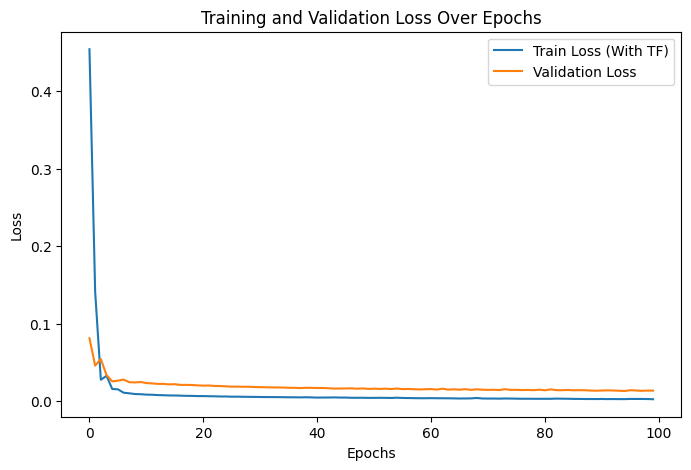

In [58]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Split into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Convert to tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

batch_size = 32
encoder = Encoder(n, 64)
encoder_t = Encoder(n, 64)
decoder = Decoder(64, 1)
decoder_t = Decoder(64, 1)

loss_fn = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adam()
optimizer_t = tf.optimizers.Adam()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

loss_history_with_tf = []
val_loss_history_with_tf = []  # Store validation loss

epochs = 100  # Define number of epochs

for epoch in range(epochs):
    total_loss_with_tf = 0  # Training loss
    total_val_loss = 0  # Validation loss

    # ------------------ Training WITH teacher forcing ------------------
    for x_batch_train, y_batch_train in train_dataset:
        with tf.GradientTape() as tape:
            outputs, hidden_state = encoder_t(x_batch_train)
            context = hidden_state
            predictions, _ = decoder_t(y_batch_train, hidden_state, context, teacher_forcing=True)

            # Compute loss
            loss = loss_fn(y_batch_train, predictions)
            total_loss_with_tf += loss.numpy()

        # Compute gradients and update weights
        gradients = tape.gradient(loss, encoder_t.trainable_variables + decoder_t.trainable_variables)
        optimizer_t.apply_gradients(zip(gradients, encoder_t.trainable_variables + decoder_t.trainable_variables))

    avg_loss_with_tf = total_loss_with_tf / len(train_dataset)
    loss_history_with_tf.append(avg_loss_with_tf)

    # ------------------ Validation Loss Calculation ------------------
    for x_batch_val, y_batch_val in val_dataset:
        outputs, hidden_state = encoder_t(x_batch_val)
        context = hidden_state
        predictions, _ = decoder_t(y_batch_val, hidden_state, context, teacher_forcing=True)

        # Compute validation loss
        loss = loss_fn(y_batch_val, predictions)
        total_val_loss += loss.numpy()

    avg_val_loss = total_val_loss / len(val_dataset)
    val_loss_history_with_tf.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss (With TF): {avg_loss_with_tf:.4f}, Validation Loss: {avg_val_loss:.4f}")

# ------------------ Final Test Loss Calculation ------------------
total_test_loss = 0
for x_batch_test, y_batch_test in test_dataset:
    outputs, hidden_state = encoder_t(x_batch_test)
    context = hidden_state
    predictions, _ = decoder_t(y_batch_test, hidden_state, context, teacher_forcing=True)

    # Compute test loss
    loss = loss_fn(y_batch_test, predictions)
    total_test_loss += loss.numpy()

avg_test_loss = total_test_loss / len(test_dataset)

print(f"\nFinal Test Loss: {avg_test_loss:.4f}")

# ------------------ Plot Training and Validation Loss ------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), loss_history_with_tf, label="Train Loss (With TF)")
plt.plot(range(epochs), val_loss_history_with_tf, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Over Epochs")
plt.show()

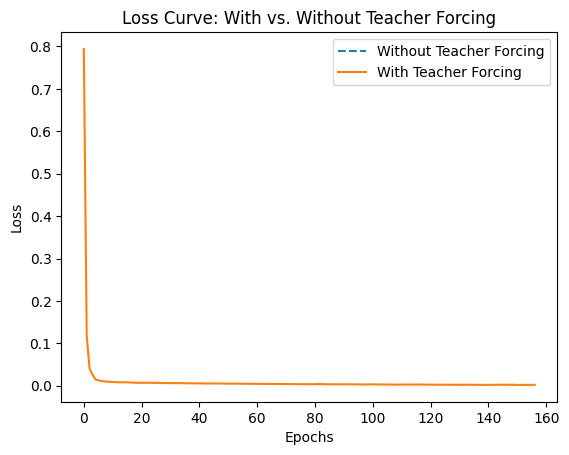

Test Loss: 0.8797901272773743
Test Loss: 0.7367457151412964
Test Loss: 1.3078467845916748


In [56]:

# Plot the training loss curves
plt.plot(loss_history_without_tf, label="Without Teacher Forcing", linestyle="dashed")
plt.plot(loss_history_with_tf, label="With Teacher Forcing")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve: With vs. Without Teacher Forcing")
plt.legend()
plt.show()
#test 
for x_batch_test, y_batch_test in test_dataset:
    outputs, hidden_state = encoder(x_batch_test)
    context = hidden_state
    predictions, _ = decoder(y_batch_test, hidden_state, context, teacher_forcing=False)
    loss = loss_fn(y_batch_test, predictions)
    print(f"Test Loss: {loss.numpy()}")
    


In [13]:
# import matplotlib.pyplot as plt
# plt.plot(data["Close"].values)
X = np.lib.stride_tricks.sliding_window_view(data.values, window_shape=(seq,n))[::y_seq][:-1]
y = np.lib.stride_tricks.sliding_window_view(data["Close"].values, window_shape=(y_seq))[seq::y_seq]
X = np.reshape(X,(X.shape[0],X.shape[2],X.shape[3]))
X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

#std normalization
X = (X - np.mean(X,axis=0))/np.std(X,axis=0)
y = (y - np.mean(y))/np.std(y)


X.shape,y.shape

(TensorShape([343, 10, 8]), TensorShape([343, 10]))

In [14]:
# outputs, hidden_state = encoder(X[:,:,:])
# context = hidden_state[0]
# predictions, _ = decoder(y[:,:], hidden_state, context, teacher_forcing=False)


Training with x_seq=20, y_seq=10
Epoch 1, Train Loss: 0.4847
Epoch 2, Train Loss: 0.0703
Epoch 3, Train Loss: 0.0336
Epoch 4, Train Loss: 0.0198
Epoch 5, Train Loss: 0.0120
Epoch 6, Train Loss: 0.0113
Epoch 7, Train Loss: 0.0100
Epoch 8, Train Loss: 0.0096
Epoch 9, Train Loss: 0.0095
Epoch 10, Train Loss: 0.0087
Epoch 11, Train Loss: 0.0081
Epoch 12, Train Loss: 0.0085
Epoch 13, Train Loss: 0.0081
Epoch 14, Train Loss: 0.0080
Epoch 15, Train Loss: 0.0080
Epoch 16, Train Loss: 0.0081
Epoch 17, Train Loss: 0.0079
Epoch 18, Train Loss: 0.0073
Epoch 19, Train Loss: 0.0076
Epoch 20, Train Loss: 0.0072
Epoch 21, Train Loss: 0.0070
Epoch 22, Train Loss: 0.0069
Epoch 23, Train Loss: 0.0069
Epoch 24, Train Loss: 0.0069
Epoch 25, Train Loss: 0.0070
Epoch 26, Train Loss: 0.0072
Epoch 27, Train Loss: 0.0068
Epoch 28, Train Loss: 0.0064
Epoch 29, Train Loss: 0.0066
Epoch 30, Train Loss: 0.0064
Epoch 31, Train Loss: 0.0062
Epoch 32, Train Loss: 0.0064
Epoch 33, Train Loss: 0.0063
Epoch 34, Train Lo

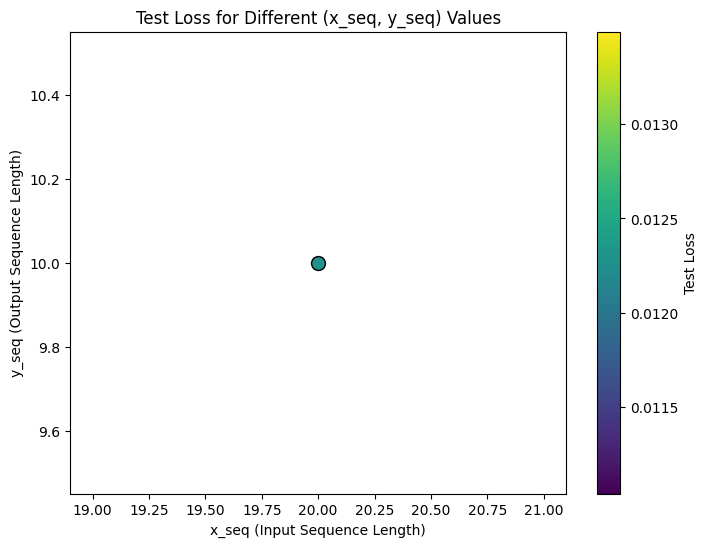

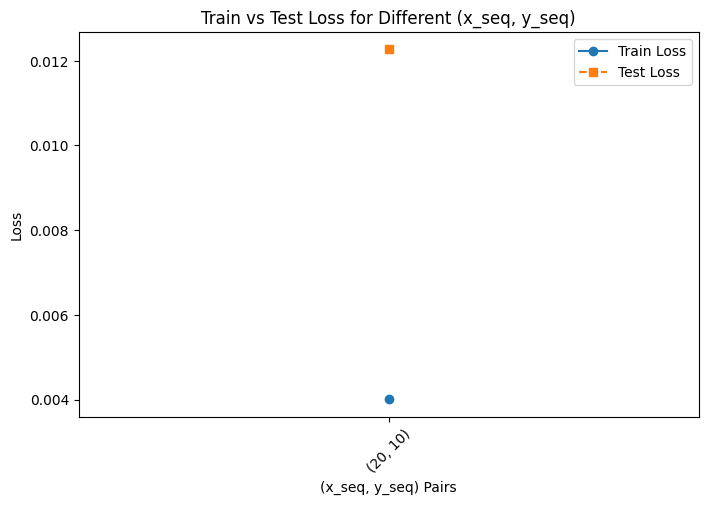

In [47]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def train_and_evaluate(data, seq_list, y_seq_list, epochs=50, batch_size=32, n_units=64):
    """
    Trains and evaluates the model for different (x_seq, y_seq) values.

    Returns:
    - losses: A dictionary storing train and test losses for each (x_seq, y_seq).
    - Generates plots for test loss distribution and train vs. test loss.
    """

    losses = {}  # Store both train and test losses

    for seq in seq_list:
        for y_seq in y_seq_list:
            print(f"\nTraining with x_seq={seq}, y_seq={y_seq}")

            # Data preprocessing
            n = len(data.columns)
            X = np.lib.stride_tricks.sliding_window_view(data.values, window_shape=(seq, n))[::y_seq][:-1]
            y = np.lib.stride_tricks.sliding_window_view(data["Close"].values, window_shape=(y_seq))[seq::y_seq]

            # Reshape X
            X = np.reshape(X, (X.shape[0], X.shape[2], X.shape[3]))

            # Standard normalization
            X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
            y = (y - np.mean(y)) / np.std(y)

            # Split data into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

            # Convert to tensors
            X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
            X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
            y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
            y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

            # Define models
            encoder = Encoder(n, n_units)
            decoder = Decoder(n_units, 1)

            # Loss function and optimizer
            loss_fn = tf.losses.MeanSquaredError()
            optimizer = tf.optimizers.Adam()

            # Create dataset batches
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
            test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(1000).batch(batch_size)

            # Store loss history
            loss_history = []

            # Training loop
            for epoch in range(epochs):
                total_train_loss = 0

                for x_batch_train, y_batch_train in train_dataset:
                    with tf.GradientTape() as tape:
                        outputs, hidden_state = encoder(x_batch_train)
                        context = hidden_state
                        predictions, _ = decoder(y_batch_train, hidden_state, context, teacher_forcing=False)
                        loss = loss_fn(y_batch_train, predictions)
                        total_train_loss += loss.numpy()

                    gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))

                avg_train_loss = total_train_loss / len(train_dataset)
                loss_history.append(avg_train_loss)
                print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

            # Evaluate on test set
            total_test_loss = 0
            for x_batch_test, y_batch_test in test_dataset:
                outputs, hidden_state = encoder(x_batch_test)
                context = hidden_state
                predictions, _ = decoder(y_batch_test, hidden_state, context, teacher_forcing=False)
                loss = loss_fn(y_batch_test, predictions)
                total_test_loss += loss.numpy()

            avg_test_loss = total_test_loss / len(test_dataset)

            # Store final train and test loss
            losses[(seq, y_seq)] = {"train_loss": loss_history[-1], "test_loss": avg_test_loss}
            print(f"Final Train Loss: {loss_history[-1]:.4f}, Test Loss: {avg_test_loss:.4f}")

    # ===========================
    # Plot 1: Test Loss Heatmap
    # ===========================
    plt.figure(figsize=(8, 6))
    for (seq, y_seq), loss in losses.items():
        plt.scatter(seq, y_seq, s=100, c=loss["test_loss"], cmap='viridis', edgecolors='k', label=f'Test Loss={loss["test_loss"]:.4f}')
    
    plt.colorbar(label="Test Loss")
    plt.xlabel("x_seq (Input Sequence Length)")
    plt.ylabel("y_seq (Output Sequence Length)")
    plt.title("Test Loss for Different (x_seq, y_seq) Values")
    plt.show()

    # ===========================
    # Plot 2: Train vs Test Loss
    # ===========================
    seq_y_pairs = list(losses.keys())
    train_losses = [losses[k]["train_loss"] for k in seq_y_pairs]
    test_losses = [losses[k]["test_loss"] for k in seq_y_pairs]

    plt.figure(figsize=(8, 5))
    plt.plot(range(len(seq_y_pairs)), train_losses, marker="o", linestyle="-", label="Train Loss")
    plt.plot(range(len(seq_y_pairs)), test_losses, marker="s", linestyle="--", label="Test Loss")
    plt.xticks(range(len(seq_y_pairs)), [str(k) for k in seq_y_pairs], rotation=45)
    plt.xlabel("(x_seq, y_seq) Pairs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Train vs Test Loss for Different (x_seq, y_seq)")
    plt.show()

    return losses


# Example usage:
seq_list = [20]  # Different input sequence lengths
y_seq_list = [10] # Different output sequence lengths

test_losses = train_and_evaluate(data, seq_list, y_seq_list, epochs=100, batch_size=32)
# print(test_losses)

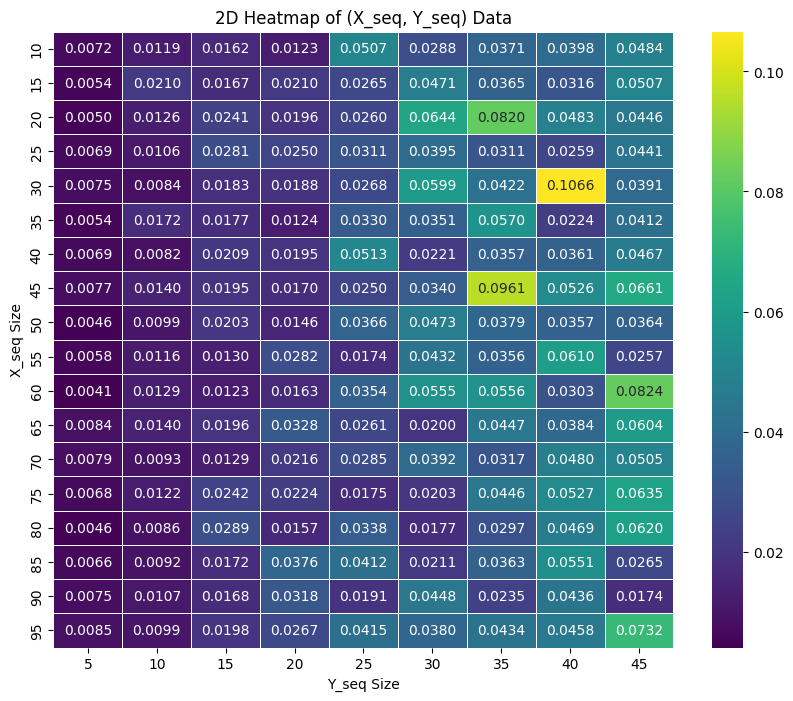

In [44]:
import matplotlib.pyplot as plt
# plt.plot(y.numpy().flatten())
# predictions.shape
# plt.plot(predictions.numpy().flatten())
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert dictionary to DataFrame
df = pd.DataFrame(list(test_losses.items()), columns=["(X_seq, Y_seq)", "Value"])
df["X_seq"], df["Y_seq"] = zip(*df["(X_seq, Y_seq)"])
df.drop(columns=["(X_seq, Y_seq)"], inplace=True)

# Pivot to create a heatmap-compatible matrix
heatmap_data = df.pivot(index="X_seq", columns="Y_seq", values="Value")

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".4f", linewidths=0.5)
plt.title("2D Heatmap of (X_seq, Y_seq) Data")
plt.xlabel("Y_seq Size")
plt.ylabel("X_seq Size")
plt.show()

In [51]:

outputs, hidden_state = encoder(X[0:1,:,:])
context = hidden_state[0]
predictions, _ = decoder(y[0:1,:], hidden_state, context, teacher_forcing=False)
predictions

<tf.Tensor: shape=(1, 10, 1), dtype=float32, numpy=
array([[[-1.8714153],
        [-1.865092 ],
        [-1.8779595],
        [-1.8866004],
        [-1.8963846],
        [-1.9078633],
        [-1.9194074],
        [-1.9300207],
        [-1.9392998],
        [-1.9472418]]], dtype=float32)>

In [52]:
outputs, hidden_state = encoder(X[1:2,:,:])
context2 = hidden_state[0]
predictions, _ = decoder(y[1:2,:], hidden_state, context2, teacher_forcing=False)
predictions

<tf.Tensor: shape=(1, 10, 1), dtype=float32, numpy=
array([[[-1.9048665],
        [-1.8973863],
        [-1.9172713],
        [-1.9212368],
        [-1.9227629],
        [-1.9263875],
        [-1.9314488],
        [-1.9370364],
        [-1.9425179],
        [-1.9476175]]], dtype=float32)>

In [29]:
data = utils.process_stock_data("AAPL","max","1h")
data = data.dropna()

X_slide_y_seq = np.lib.stride_tricks.sliding_window_view(data.values, window_shape=(seq,n))[::y_seq][:-1]
X_slide_y_seq = np.reshape(X_slide_y_seq,(X_slide_y_seq.shape[0],X_slide_y_seq.shape[2],X_slide_y_seq.shape[3]))
y_slide_y_seq = np.lib.stride_tricks.sliding_window_view(data["Close"].values, window_shape=(y_seq))[seq::y_seq]
X_slide_y_seq = tf.convert_to_tensor(X_slide_y_seq, dtype=tf.float32)
y_slide_y_seq = tf.convert_to_tensor(y_slide_y_seq, dtype=tf.float32)

#std normalization
X_slide_y_seq = (X_slide_y_seq - np.mean(X_slide_y_seq,axis=0))/np.std(X_slide_y_seq,axis=0)
y_slide_y_seq = (y_slide_y_seq - np.mean(y_slide_y_seq))/np.std(y_slide_y_seq)

pre = []
for t in range(100):
    outputs, hidden_state = encoder(X_slide_y_seq[t:t+1,:,:])
    context = hidden_state[0]
    predictions, _ = decoder(y_slide_y_seq[t:t+1,:], hidden_state, context, teacher_forcing=False)
    
    pre.append(predictions.numpy().flatten())

In [30]:
pre = np.array(pre).flatten()
pre

array([-1.74649858e+00, -1.70716083e+00, -1.71262288e+00, -1.70360053e+00,
       -1.68615174e+00, -1.66932189e+00, -1.65672576e+00, -1.64820278e+00,
       -1.64252496e+00, -1.63931644e+00, -1.42047811e+00, -1.41083145e+00,
       -1.45813775e+00, -1.48869216e+00, -1.51015532e+00, -1.52584660e+00,
       -1.53799057e+00, -1.54781246e+00, -1.55596423e+00, -1.56280708e+00,
       -1.54010201e+00, -1.50422251e+00, -1.51974475e+00, -1.53520441e+00,
       -1.54462314e+00, -1.55017245e+00, -1.55290425e+00, -1.55365002e+00,
       -1.55310833e+00, -1.55182195e+00, -1.51830149e+00, -1.52944195e+00,
       -1.55062222e+00, -1.56646073e+00, -1.57390666e+00, -1.57547927e+00,
       -1.57341528e+00, -1.56952608e+00, -1.56481791e+00, -1.56011426e+00,
       -1.61712909e+00, -1.60623014e+00, -1.62473905e+00, -1.64261174e+00,
       -1.64951885e+00, -1.64777315e+00, -1.64181590e+00, -1.63400722e+00,
       -1.62614226e+00, -1.61907458e+00, -1.50832319e+00, -1.50642645e+00,
       -1.52566385e+00, -

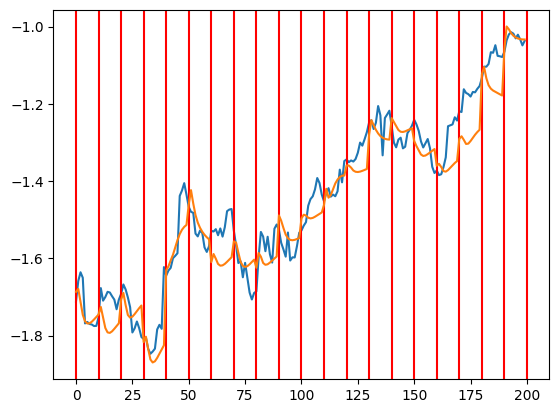

In [35]:
import matplotlib.pyplot as plt
#plot pre and y 
i = 100
a = slice(i,i+200)
plt.plot(y_slide_y_seq.numpy().flatten()[a])
#each 10 draw line
for i in range(0,21):
    plt.axvline(x=i*10,color="red")
plt.plot(pre[a])